<h1><center>Main Notebook - Decision Tree</center></h1>

# Imports & Setup

In [2]:
%load_ext autoreload
%autoreload 2
from utils import *
import utils.transformers.transformers as tr
import utils.transformers.sk4pandas as s4p

import os
import pickle
import urllib.request

import git
from IPython.core.magic import register_cell_magic
from matplotlib.pyplot import figure
import mlflow
import pandas as pd
from sklearn.base import clone
from sklearn.compose import make_column_selector
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, loguniform
from sklearn.tree import DecisionTreeClassifier, plot_tree


git_repo = git.Repo(os.getcwd())

@register_cell_magic
def run_and_save(line, cell):
    'Run and save python code block to a file'
    with open(line, 'wt') as fd:
        fd.write(cell)
    code = compile(cell, line, 'exec')
    exec(code, globals())

# Init Datasets

In [3]:
raw_main_df = pd.read_csv('data/train.csv')
raw_sub_df = pd.read_csv('data/test.csv')
raw_train_df, raw_test_df = train_test_split(raw_main_df, test_size=100, random_state=42)

X_all, y_all = raw_main_df.drop('Survived', axis=1), raw_main_df['Survived']
X_train, y_train = raw_train_df.drop('Survived', axis=1), raw_train_df['Survived']
X_test, y_test = raw_test_df.drop('Survived', axis=1), raw_test_df['Survived']

raw_train_df.sample(5, random_state=42)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
678,679,0,3,"Goodwin, Mrs. Frederick (Augusta Tyler)",female,43.0,1,6,CA 2144,46.9000,NaN,S
49,50,0,3,"Arnold-Franchi, Mrs. Josef (Josefine Franchi)",female,18.0,1,0,349237,17.8000,NaN,S
691,692,1,3,"Karun, Miss. Manca",female,4.0,0,1,349256,13.4167,NaN,C
499,500,0,3,"Svensson, Mr. Olof",male,24.0,0,0,350035,7.7958,NaN,S
303,304,1,2,"Keane, Miss. Nora A",female,NaN,0,0,226593,12.3500,E101,Q


# Prepare Pipeline

In [4]:
%%run_and_save blueprints/pipeline.py


clip_outliers = [
    (
        'Float',
        tr.ClipOutliers(std_band=3),
        make_column_selector(dtype_include=['float64'])
    )
]

fillna = [
    (
        'Mean',
        s4p.SimpleImputer(strategy='mean'),
        make_column_selector(dtype_include=['float64'])
    ),
    (
        'Most Frequent',
        s4p.SimpleImputer(strategy='most_frequent'),
        make_column_selector(dtype_include=['int64', 'object'])
    )
]

standardize = [
    (
        'Floats Ints',
        s4p.StandardScaler(),
        ['Age', 'Fare']
    )
]


steps_main = [
    ('Format Cabins', tr.Cabin() ),
    ('Set working columns', tr.SetupFeatures(cols_ignore=['PassengerId', 'Name', 'Ticket', 'Parch']) ),
    ('Clip Outliers', s4p.ColumnTransformer(clip_outliers, remainder='passthrough') ),
    ('Standardize', s4p.ColumnTransformer(standardize, remainder='passthrough')),
    ('Fill NaN', s4p.ColumnTransformer(fillna, remainder='passthrough') ),
    ('Convert Types', tr.AsTypes(coltypes_overwrite={'Age': 'float64'}) ),
    ('One Hot', s4p.OneHotEncoder(cols_select=['Pclass', 'Sex', 'Cabin', 'SibSp', 'Embarked']) ),
    ('Decision Tree', DecisionTreeClassifier())
]

pipe = Pipeline(steps_main)

# Grid Params

In [5]:
%%run_and_save blueprints/grid_params.py

n_iter = 50

ml_params_distributions = {
    'Decision Tree__min_samples_split': loguniform(40, 100).rvs(n_iter).astype('int'),
}

rs = RandomizedSearchCV (
    pipe,
    param_distributions = ml_params_distributions,
    n_iter=n_iter,
    n_jobs=-1,
    refit=True,
    cv=CVSplitter(5, 80),
    return_train_score=True
)

# ML Flow Run

In [ ]:
mlflow.sklearn.autolog(max_tuning_runs=3)

with mlflow.start_run(run_name='Decision Tree') as run:
    mlflow.set_tags(get_lastcommit_infos(git_repo))
    mlflow.log_artifact('blueprints/pipeline.py', 'blueprints')
    mlflow.log_artifact('blueprints/grid_params.py', 'blueprints')
    rs.fit(X_train, y_train)

# Refit best model

In [6]:
run_id = '693a74b12d4e4cfc88417f694fae7ed5'
#url_local_model = f'file:///Users/i538262/Desktop/Developments/PERSO/KAGGLE%20Titanic/mlruns/0/{run_id}/artifacts/model/model.pkl'
url_local_model = f'file:///Users/i538262/Desktop/Developments/PERSO/KAGGLE%20Titanic/mlruns/0/{run_id}/artifacts/best_estimator/model.pkl'

with urllib.request.urlopen(url_local_model) as model_file:
    best_model = pickle.load(model_file)
    
best_model_allfit = clone(best_model)
best_model_allfit.fit(X_all, y_all)

Pipeline(steps=[('Format Cabins', Cabin()),
                ('Set working columns',
                 SetupFeatures(cols_ignore=['PassengerId', 'Name', 'Ticket',
                                            'Parch'])),
                ('Clip Outliers',
                 ColumnTransformer(Float__cols_ignore=[], Float__cols_select=[],
                                   Float__std_band=3,
                                   transformers=[('Float',
                                                  ClipOutliers(std_band=3),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7faecee41...
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7faecee4c070>),
                                                 ('Most Frequent',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  <s

# Submit models predictions

In [ ]:
branch_name = get_lastcommit_infos(git_repo)['Branch']
submit(f'submissions/{branch_name}/{run_id}.csv', raw_sub_df.PassengerId, best_model_allfit.predict(raw_sub_df))

# Model insights

[Text(0.5, 0.9642857142857143, 'Sex_male <= 0.5\ngini = 0.473\nsamples = 891\nvalue = [549, 342]'),
 Text(0.3125, 0.8928571428571429, 'Pclass_3 <= 0.5\ngini = 0.383\nsamples = 314\nvalue = [81, 233]'),
 Text(0.125, 0.8214285714285714, 'Age <= -1.877\ngini = 0.1\nsamples = 170\nvalue = [9, 161]'),
 Text(0.0625, 0.75, 'gini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0.1875, 0.75, 'Fare <= -0.031\ngini = 0.091\nsamples = 168\nvalue = [8, 160]'),
 Text(0.125, 0.6785714285714286, 'gini = 0.182\nsamples = 69\nvalue = [7, 62]'),
 Text(0.25, 0.6785714285714286, 'Fare <= 3.22\ngini = 0.02\nsamples = 99\nvalue = [1, 98]'),
 Text(0.1875, 0.6071428571428571, 'gini = 0.0\nsamples = 81\nvalue = [0, 81]'),
 Text(0.3125, 0.6071428571428571, 'gini = 0.105\nsamples = 18\nvalue = [1, 17]'),
 Text(0.5, 0.8214285714285714, 'Fare <= -0.18\ngini = 0.5\nsamples = 144\nvalue = [72, 72]'),
 Text(0.4375, 0.75, 'Age <= -0.151\ngini = 0.484\nsamples = 117\nvalue = [48, 69]'),
 Text(0.375, 0.6785714285714286, 'gin

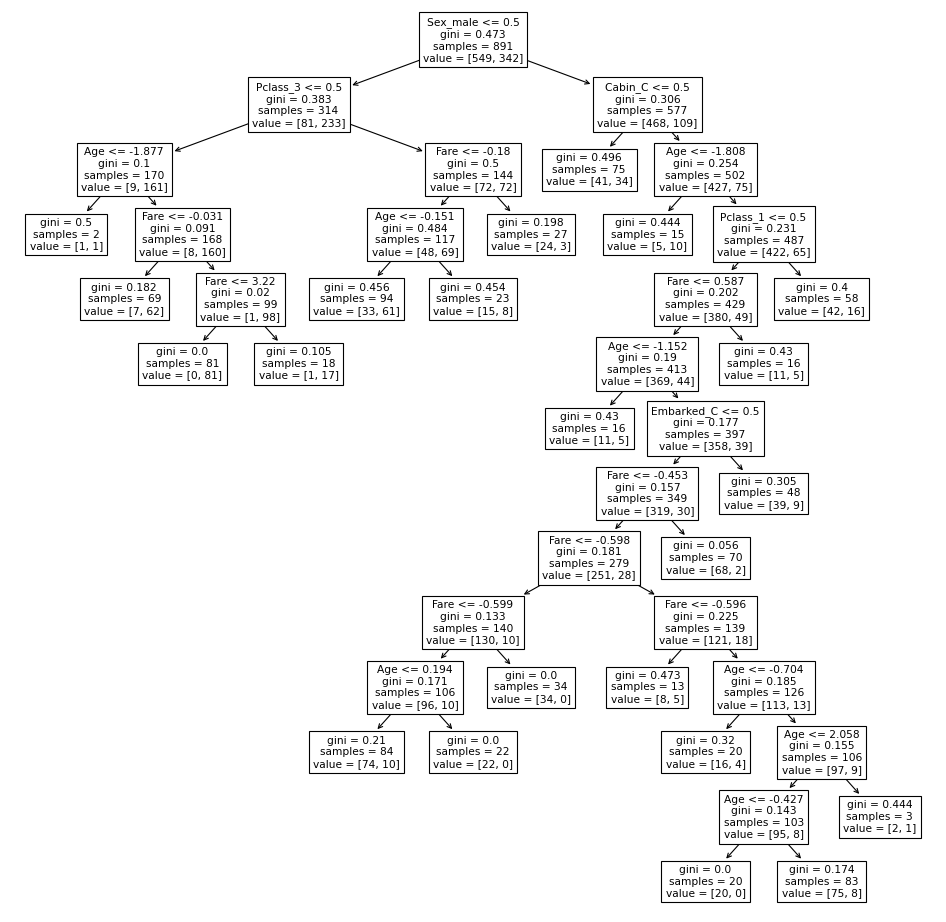

In [7]:
best_model_allfit[:-1].transform(X_all).columns
figure(figsize=(15, 15), dpi=80)

plot_tree(best_model_allfit[-1], feature_names=best_model_allfit[:-1].transform(X_all).columns)

# Code tests